In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 5
%autosave 15

import os
import sys

import math
import sklearn as sk
import sklearn.cross_validation as cv
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import operator
import time
#import h2o
#from h2o import H2OFrame
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier, RandomForestRegressor, GradientBoostingRegressor
from mpl_toolkits.mplot3d import Axes3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 15 seconds


In [6]:
gg = pd.read_csv("h2o_rf.csv")
gg.head()

,Id,Sales
0,1,4374.522972
1,857,4658.010524
2,1713,4841.911267
3,2569,5133.444710
4,3425,3721.321348


In [7]:
os.getenv("kk1")

In [7]:
h2o.init()

H2O cluster uptime:,10 seconds 334 milliseconds
H2O cluster version:,3.2.0.9
H2O cluster name:,kk1
H2O cluster total nodes:,1
H2O cluster total memory:,1.78 GB
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321


In [3]:
def scale(feature):
    return map(lambda x: math.log(x + 1), feature)
def recover(feature):
    return map(lambda x: math.pow(math.e, x) - 1, feature)
def scaleFeatures(dataF, features):
    data1 = dataF.copy()
    for f in features:
        data1[f] = scale(data1[f])
    return data1
def recoveFeatures(dataF, features):
    data1 = dataF.copy()
    for f in features:
        data1[f] = recover(data1[f])
    return data1
def calcRMSPE(test, predict):
    mpe = 0
    len1 = 0
    for t,p in zip(test, predict):
        if (t == 0):
            continue
        mpe += math.pow(1.0*(t - p)/t, 2)
        len1 +=1
    mpe = mpe / len1
    rmpe = math.sqrt(mpe)
    return rmpe
def getAccuracy(test, predict):
    accs = {}
    accs['RMSE'] = math.sqrt(mean_squared_error(test, predict))
    accs['MAE'] = mean_absolute_error(test, predict)
    accs['RMSPE'] = calcRMSPE(test,predict)
    return accs
def parseDate(data):
    data1 = data.copy()
    data1['Month'] = data1.Date.apply(lambda x: time.strptime(x, "%Y-%m-%d").tm_mon)
    data1['Day'] = data1.Date.apply(lambda x: time.strptime(x, "%Y-%m-%d").tm_mday)
    #data1['Year'] = data1.Date.apply(lambda x: time.strptime(x, "%Y-%m-%d").tm_year)
    return data1
def strToNumeric(data, columns):
    data1 = data.copy()
    for col in columns:
        uniq = data[col].drop_duplicates()
        k = 0
        for u in uniq:
            data1[col] = data1[col].replace(u, k)
            k += 1
    return data1

In [4]:
#preprocessing
data = pd.read_csv("Data/train.csv")
data = strToNumeric(data, ['StateHoliday'])
data = parseDate(data)
data = data.drop(['Date','Customers'], axis = 1)

stores = pd.read_csv("Data/store.csv")
stores = stores.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)
stores = strToNumeric(stores, ['StoreType', 'Assortment'])
stores = stores.fillna(stores.CompetitionDistance.mean())

data_mod = pd.merge(data, stores, on='Store')
#data_mod = scaleFeatures(data_mod, ['Sales'])
data_mod.head()

/usr/local/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,Month,Day,StoreType,Assortment,CompetitionDistance
0,1,5,5263,1,1,4,1,7,31,0,0,1270
1,1,4,5020,1,1,4,1,7,30,0,0,1270
2,1,3,4782,1,1,4,1,7,29,0,0,1270
3,1,2,5011,1,1,4,1,7,28,0,0,1270
4,1,1,6102,1,1,4,1,7,27,0,0,1270


In [14]:
dummies1 = pd.get_dummies(data_mod['StateHoliday'], prefix="SH")
dummies2 = pd.get_dummies(data_mod['StoreType'], prefix="ST")
dummies3 = pd.get_dummies(data_mod['Assortment'], prefix="ASS")
df = pd.concat([data_mod, dummies1, dummies2, dummies3], axis = 1)
df = df.drop(['StoreType', 'StateHoliday', 'Assortment'], axis = 1)
df.index.name = "Id"
df.to_csv("mod_train.csv")
pd.read_csv("mod_train.csv").head()

,Id,Store,DayOfWeek,Sales,Open,Promo,SchoolHoliday,Month,Day,CompetitionDistance,...,SH_2,SH_3,SH_4,ST_0,ST_1,ST_2,ST_3,ASS_0,ASS_1,ASS_2
0,0,1,5,5263,1,1,1,7,31,1270,...,0,0,1,1,0,0,0,1,0,0
1,1,1,4,5020,1,1,1,7,30,1270,...,0,0,1,1,0,0,0,1,0,0
2,2,1,3,4782,1,1,1,7,29,1270,...,0,0,1,1,0,0,0,1,0,0
3,3,1,2,5011,1,1,1,7,28,1270,...,0,0,1,1,0,0,0,1,0,0
4,4,1,1,6102,1,1,1,7,27,1270,...,0,0,1,1,0,0,0,1,0,0


In [58]:
train_data = data_mod
target = train_data.Sales
X_train, X_test, y_train, y_test = cv.train_test_split(train_data, target, test_size=0.2, random_state=23)
#X_test = X_test.drop("Sales", axis=1)
data.ColumnName.drop_d
X_train.to_csv("X_train.csv", columns=X_train.columns)
X_test.to_csv("X_test.csv", columns=X_test.columns)

In [59]:
htrain = h2o.import_file(path = "C:\kk1\Anaconda\Rossmann\X_train.csv")
htest_X = h2o.import_file(path = "C:\kk1\Anaconda\Rossmann\X_test.csv")
htrain = htrain.drop(0)
htest_X = htest_X.drop(0)


Parse Progress: [##################################################] 100%
Imported C:\kk1\Anaconda\Rossmann\X_train.csv. Parsed 813,767 rows and 13 cols

Parse Progress: [##################################################] 100%
Imported C:\kk1\Anaconda\Rossmann\X_test.csv. Parsed 203,442 rows and 13 cols


H2OFrame with 203442 rows and 1 columns: 
      Sales
0  9.069468
1  8.569406
2  0.000000
3  8.834191
4  8.773075
5  8.514590
6  8.247744
7  0.000000
8  8.779096
9  8.475329


In [72]:
features = ['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Month', 'Day','StoreType', 'Assortment', 'CompetitionDistance']
drf = h2o.random_forest(x = htrain.drop(2), y = htrain['Sales'], ntrees = 30, validation_x=htest_X.drop(2), validation_y=htest_X['Sales'])


drf Model Build Progress: [##################################################] 100%


In [89]:
print y_test.head(), predicts.head()

591893    9.069468
860699    8.569406
914292    0.000000
581310    8.834191
750249    8.773075
Name: Sales, dtype: float64 0    9.078070
1    8.512582
2    0.000000
3    9.008603
4    8.648857
Name: predict, dtype: float64


In [74]:
predicts = drf.predict(htrain).as_data_frame().predict
getAccuracy(recover(y_train), recover(predicts))

{'MAE': 960.74573947429667,
 'RMSE': 1543.1968039757776,
 'RMSPE': 0.2382425314039436}

In [73]:
predicts = drf.predict(htest_X).as_data_frame().predict
getAccuracy(recover(y_test), recover(predicts))

{'MAE': 1065.3775249766852,
 'RMSE': 1721.6802979924016,
 'RMSPE': 0.3103183429727282}

In [9]:
getAccuracy(recover(y_test), recover(rf.predict(X_test)))

{'MAE': 807.13475116046391,
 'RMSE': 1232.3363999626158,
 'RMSPE': 0.17368117679140724}

In [7]:
#FITTING
#Open == 0 ? Sales = 0
sep_zero = True
if (sep_zero):
    train_data = data_mod[data_mod.Open == 1]
    target = train_data.Sales
    train_data = train_data.drop(['Sales','Open'], axis = 1)
else:
    train_data = data_mod.drop(['Sales'], axis=1)
    target = data_mod.Sales
X_train, X_test, y_train, y_test = cv.train_test_split(train_data, target, test_size=0.2, random_state=23)
rf = RandomForestRegressor(n_estimators=30, min_samples_split=20, min_samples_leaf=1,n_jobs=-1)
rf.fit(X_train, y_train)
print "TEST: ", getAccuracy(y_test, rf.predict(X_test))
print "TRAIN: ", getAccuracy(y_train, rf.predict(X_train))

TEST:  {'RMSPE': 0.1751110155501171, 'MAE': 725.65805055534781, 'RMSE': 1135.7800352234028}
TRAIN:  {'RMSPE': 0.1966410952782608, 'MAE': 598.77663663536782, 'RMSE': 935.366695090752}


In [8]:
rf = RandomForestRegressor(n_estimators=200, min_samples_split=20, min_samples_leaf=1,n_jobs=-1)
rf.fit(X_train, y_train)
print "TEST: ", getAccuracy(y_test, rf.predict(X_test))
print "TRAIN: ", getAccuracy(y_train, rf.predict(X_train))

TEST:  {'RMSPE': 0.17473127011246672, 'MAE': 722.82745902523482, 'RMSE': 1132.0496633481528}
TRAIN:  {'RMSPE': 0.19831187155136626, 'MAE': 595.47331678972478, 'RMSE': 929.3711144152458}


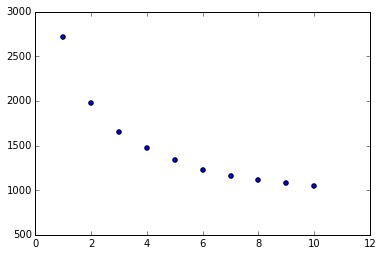

In [11]:
#PARAMS
n_est = [5,10,30,50,80]
m_dep = [1,2,3,4,5,6,7,8,9,10]

scores = []
for par in m_dep:
    rf_s = RandomForestRegressor(n_jobs=-1, max_depth=par)
    rf_s.fit(X_train, y_train)
    scores.append(math.sqrt(mean_squared_error(y_test, rf_s.predict(X_test))))
plt.scatter(m_dep, scores)

In [59]:
data11 = pd.read_csv("train.csv")
data11.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [43]:
test = pd.read_csv("test.csv")
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1,1,0,0
1,2,3,4,2015-09-17,1,1,0,0
2,3,7,4,2015-09-17,1,1,0,0
3,4,8,4,2015-09-17,1,1,0,0
4,5,9,4,2015-09-17,1,1,0,0


In [21]:
test.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,1,1,0,0
1,2,3,4,1,1,0,0
2,3,7,4,1,1,0,0
3,4,8,4,1,1,0,0
4,5,9,4,1,1,0,0


In [19]:
test = pd.read_csv("test.csv")
test = strToNumeric(test, ['StateHoliday'])
#test = parseDate(test)
test = test.drop("Date", axis = 1)

stores = pd.read_csv("store.csv")
stores = stores.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)
stores = strToNumeric(stores, ['StoreType', 'Assortment'])

test_mod = pd.merge(test, stores, on='Store')
#test_mod = scaleFeatures(test_mod, ['Customers'])
test_mod = test_mod.fillna(0)
test_mod = test_mod.sort("Id")
test_mod = test_mod.drop('Id', axis = 1)
test_mod.head()

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance
0,1,4,1,1,0,0,0,0,1270
48,3,4,1,1,0,0,1,0,14130
96,7,4,1,1,0,0,1,1,24000
144,8,4,1,1,0,0,1,0,7520
192,9,4,1,1,0,0,1,1,2030


In [20]:
data_mod = test_mod
dummies1 = pd.get_dummies(data_mod['StateHoliday'], prefix="SH")
dummies2 = pd.get_dummies(data_mod['StoreType'], prefix="ST")
dummies3 = pd.get_dummies(data_mod['Assortment'], prefix="ASS")
df = pd.concat([data_mod, dummies1, dummies2, dummies3], axis = 1)
df = df.drop(['StoreType', 'StateHoliday', 'SchoolHoliday'], axis = 1)
df.index.name = "Id"
df.to_csv("mod_test.csv")
pd.read_csv("mod_test.csv").head()

,Id,Store,DayOfWeek,Open,Promo,Assortment,CompetitionDistance,SH_0,SH_1,ST_0,ST_1,ST_2,ST_3,ASS_0,ASS_1,ASS_2
0,0,1,4,1,1,0,1270,1,0,1,0,0,0,1,0,0
1,48,3,4,1,1,0,14130,1,0,0,1,0,0,1,0,0
2,96,7,4,1,1,1,24000,1,0,0,1,0,0,0,1,0
3,144,8,4,1,1,0,7520,1,0,0,1,0,0,1,0,0
4,192,9,4,1,1,1,2030,1,0,0,1,0,0,0,1,0


In [65]:
test_h2o = H2OFrame(test_mod.to_dict("list"))
preds = recover(drf.predict(test_h2o).as_data_frame().predict)



Parse Progress: [##################################################] 100%
Uploaded py39db4f41-870c-4683-8eb9-f09cca4565f7 into cluster with 41,088 rows and 11 cols


In [63]:
recs = preds.as_data_frame().predict


In [67]:
sample  = pd.read_csv("sample_submission.csv", index_col="Id")
sample.Sales = preds
sample.to_csv("subm.csv", index_label="Id")
sample.head()

,Sales
Id,
1,3687.340721
2,4263.019865
3,5092.160859
4,4069.665350
5,4411.858572


In [54]:
sample  = pd.read_csv("sample_submission.csv", index_col="Id")
sample.Sales = recover(recs)
sample.to_csv("subm.csv", index_label="Id")
sample.head()

,Sales
Id,
1,5506.720495
2,6409.924102
3,5880.947829
4,6213.532895
5,6313.995701


In [44]:
preds = drf.predict(test_h2o)

In [47]:
#prediction
zero_ids = []
test_size = len(test_mod)
for i in range(0, test_size):
    if (test_mod.iloc[i].Open == 0):
        zero_ids.append(i)

predicts = rf.predict(test_mod.drop(['Id', 'Open'], axis=1))
predicts = recover(predicts)
for i in zero_ids:
    predicts[i] = 0
    
sample  = pd.read_csv("sample_submission.csv", index_col="Id")
sample.Sales = sample.Sales.apply(lambda x: float(x))
sample.Sales = predicts
sample.to_csv("subm.csv", index_label="Id")
sample.head()

,Sales
Id,
1,4975.300895
2,7814.871120
3,8888.334065
4,7024.629400
5,6499.614864


In [48]:
mysubm = pd.read_csv("subm.csv")
mysubm.head()

,Id,Sales
0,1,4975.300895
1,2,7814.871120
2,3,8888.334065
3,4,7024.629400
4,5,6499.614864


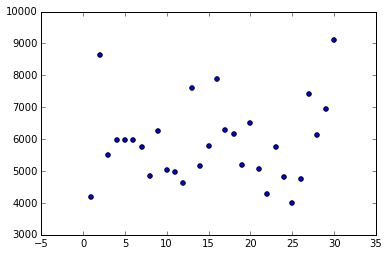

In [13]:
median_sales = []
days = []
year = 2015
for day in range(1,31):
    median_sales.append(data[(data.Day == day) & (data.Year == year)].Sales.mean())
    days.append(day)
plt.scatter(days, median_sales)

In [26]:
stores = pd.read_csv("store.csv")
stores = stores.drop(['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)
stores = strToNumeric(stores, ['StoreType', 'Assortment'])
stores.head()

,Store,StoreType,Assortment
0,1,0,0
1,2,1,0
2,3,1,0
3,4,0,1
4,5,1,0


In [ ]:
#Competition distance correlation
cdata = stores.copy()
cdata.Store = cdata.Store.apply(lambda x: data[data.Store == x].Sales.mean())
cdata.head()


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,3945.704883,c,a,1270,9,2008,0,NaN,NaN,NaN
1,4122.991507,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,5741.253715,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,8021.769639,c,c,620,9,2009,0,NaN,NaN,NaN
4,3867.110403,a,a,29910,4,2015,0,NaN,NaN,NaN


In [ ]:
len(stores[stores.Promo2SinceWeek > 0])

In [95]:
test_data = pd.read_csv("test.csv")
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1,1,0,0
1,2,3,4,2015-09-17,1,1,0,0
2,3,7,4,2015-09-17,1,1,0,0
3,4,8,4,2015-09-17,1,1,0,0
4,5,9,4,2015-09-17,1,1,0,0


In [64]:
d = pd.read_csv("train.csv")
d.StateHoliday.drop_duplicates()

0         0
63555     a
129340    b
241055    c
327680    0
Name: StateHoliday, dtype: object

In [97]:
len(test_data) - len(test_data.dropna())

11

In [94]:
len(data) - len(data.dropna())

0

10


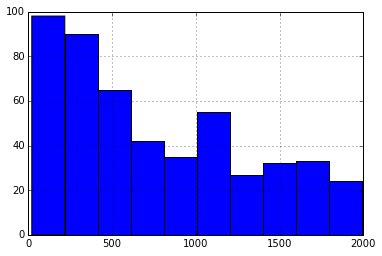

In [89]:
print len(cdata[cdata.CompetitionDistance < 50])
cdata[cdata.CompetitionDistance < 2000].CompetitionDistance.hist()

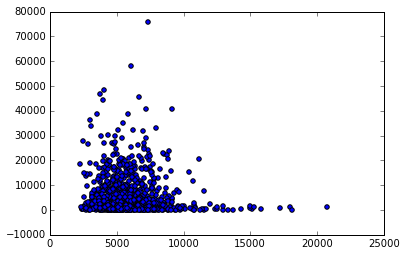

In [90]:
plt.scatter(cdata.Store, cdata.CompetitionDistance)

In [81]:
data = pd.read_csv("train.csv")
print data.shape
data.head()

(1017209, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


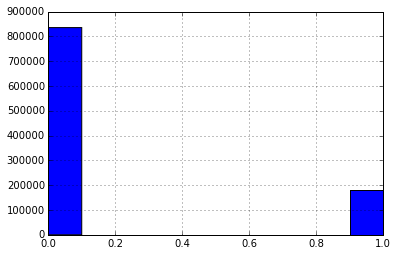

In [59]:
data.SchoolHoliday.hist()

In [61]:
print data[data.SchoolHoliday == 0].Sales.mean(), data[data.SchoolHoliday == 1].Sales.mean()

5620.97903381 6476.52220712


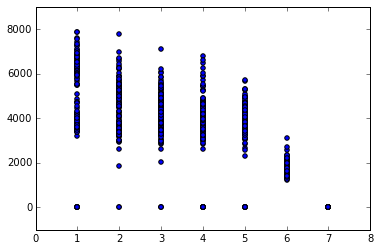

In [50]:
store = 177
plt.scatter(data[data.Store == store].DayOfWeek, data[data.Store == store].Sales)